# HAR CNN + LSTM training 

In [10]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [11]:
X_train, labels_train, list_ch_train = read_data(data_path="./data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [12]:
# Standardize
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [13]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train,
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [14]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Hyperparameters

In [16]:
lstm_size = 27         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 1000

# Fixed
n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [17]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layer(s)

Questions: 
* Should we use a different activation? Like tf.nn.tanh?
* Should we use pooling? average or max?

In [18]:
# Convolutional layers
with graph.as_default():
    # (batch, 128, 9) --> (batch, 128, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    n_ch = n_channels *2
    

Now, pass to LSTM cells

In [19]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(conv1, [1,0,2]) # reshape into (seq_len, batch, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_ch]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass and cost function:

In [20]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [ ]:
if (os.path.exists('checkpoints-crnn') == False):
    !mkdir checkpoints-crnn

In [ ]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%25 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-crnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.820212 Train acc: 0.195000
Epoch: 1/1000 Iteration: 10 Train loss: 1.805851 Train acc: 0.198333
Epoch: 1/1000 Iteration: 15 Train loss: 1.787565 Train acc: 0.220000
Epoch: 2/1000 Iteration: 20 Train loss: 1.789301 Train acc: 0.200000
Epoch: 2/1000 Iteration: 25 Train loss: 1.772577 Train acc: 0.225000
Epoch: 2/1000 Iteration: 25 Validation loss: 1.754684 Validation acc: 0.312778
Epoch: 3/1000 Iteration: 30 Train loss: 1.757486 Train acc: 0.245000
Epoch: 3/1000 Iteration: 35 Train loss: 1.747905 Train acc: 0.275000
Epoch: 4/1000 Iteration: 40 Train loss: 1.728050 Train acc: 0.278333
Epoch: 4/1000 Iteration: 45 Train loss: 1.727108 Train acc: 0.285000
Epoch: 5/1000 Iteration: 50 Train loss: 1.706027 Train acc: 0.306667
Epoch: 5/1000 Iteration: 50 Validation loss: 1.693114 Validation acc: 0.416667
Epoch: 6/1000 Iteration: 55 Train loss: 1.696254 Train acc: 0.356667
Epoch: 6/1000 Iteration: 60 Train loss: 1.683182 Train acc: 0.356667
Epoch: 7/1000 I

Epoch: 53/1000 Iteration: 480 Train loss: 0.768577 Train acc: 0.725000
Epoch: 53/1000 Iteration: 485 Train loss: 0.745624 Train acc: 0.785000
Epoch: 54/1000 Iteration: 490 Train loss: 0.752024 Train acc: 0.755000
Epoch: 54/1000 Iteration: 495 Train loss: 0.755776 Train acc: 0.751667
Epoch: 55/1000 Iteration: 500 Train loss: 0.707066 Train acc: 0.788333
Epoch: 55/1000 Iteration: 500 Validation loss: 0.613790 Validation acc: 0.886111
Epoch: 56/1000 Iteration: 505 Train loss: 0.691065 Train acc: 0.805000
Epoch: 56/1000 Iteration: 510 Train loss: 0.707045 Train acc: 0.780000
Epoch: 57/1000 Iteration: 515 Train loss: 0.707216 Train acc: 0.803333
Epoch: 57/1000 Iteration: 520 Train loss: 0.674143 Train acc: 0.818333
Epoch: 58/1000 Iteration: 525 Train loss: 0.672850 Train acc: 0.805000
Epoch: 58/1000 Iteration: 525 Validation loss: 0.572206 Validation acc: 0.896667
Epoch: 58/1000 Iteration: 530 Train loss: 0.659299 Train acc: 0.816667
Epoch: 59/1000 Iteration: 535 Train loss: 0.671344 Train 

Epoch: 105/1000 Iteration: 950 Validation loss: 0.217218 Validation acc: 0.948333
Epoch: 106/1000 Iteration: 955 Train loss: 0.317807 Train acc: 0.931667
Epoch: 106/1000 Iteration: 960 Train loss: 0.314952 Train acc: 0.936667
Epoch: 107/1000 Iteration: 965 Train loss: 0.311310 Train acc: 0.946667
Epoch: 107/1000 Iteration: 970 Train loss: 0.306601 Train acc: 0.931667
Epoch: 108/1000 Iteration: 975 Train loss: 0.328082 Train acc: 0.933333
Epoch: 108/1000 Iteration: 975 Validation loss: 0.214680 Validation acc: 0.946667
Epoch: 108/1000 Iteration: 980 Train loss: 0.283785 Train acc: 0.951667
Epoch: 109/1000 Iteration: 985 Train loss: 0.306368 Train acc: 0.921667
Epoch: 109/1000 Iteration: 990 Train loss: 0.333584 Train acc: 0.928333
Epoch: 110/1000 Iteration: 995 Train loss: 0.287255 Train acc: 0.941667
Epoch: 111/1000 Iteration: 1000 Train loss: 0.286897 Train acc: 0.940000
Epoch: 111/1000 Iteration: 1000 Validation loss: 0.207233 Validation acc: 0.949444
Epoch: 111/1000 Iteration: 1005 

Epoch: 156/1000 Iteration: 1410 Train loss: 0.204086 Train acc: 0.956667
Epoch: 157/1000 Iteration: 1415 Train loss: 0.231255 Train acc: 0.955000
Epoch: 157/1000 Iteration: 1420 Train loss: 0.219523 Train acc: 0.943333
Epoch: 158/1000 Iteration: 1425 Train loss: 0.269358 Train acc: 0.941667
Epoch: 158/1000 Iteration: 1425 Validation loss: 0.163675 Validation acc: 0.951111
Epoch: 158/1000 Iteration: 1430 Train loss: 0.207451 Train acc: 0.960000
Epoch: 159/1000 Iteration: 1435 Train loss: 0.255504 Train acc: 0.935000
Epoch: 159/1000 Iteration: 1440 Train loss: 0.236518 Train acc: 0.935000
Epoch: 160/1000 Iteration: 1445 Train loss: 0.240639 Train acc: 0.943333
Epoch: 161/1000 Iteration: 1450 Train loss: 0.218593 Train acc: 0.948333
Epoch: 161/1000 Iteration: 1450 Validation loss: 0.165448 Validation acc: 0.948889
Epoch: 161/1000 Iteration: 1455 Train loss: 0.217246 Train acc: 0.955000
Epoch: 162/1000 Iteration: 1460 Train loss: 0.218003 Train acc: 0.955000
Epoch: 162/1000 Iteration: 1465

Epoch: 207/1000 Iteration: 1870 Train loss: 0.197786 Train acc: 0.950000
Epoch: 208/1000 Iteration: 1875 Train loss: 0.199966 Train acc: 0.948333
Epoch: 208/1000 Iteration: 1875 Validation loss: 0.146860 Validation acc: 0.948889
Epoch: 208/1000 Iteration: 1880 Train loss: 0.157128 Train acc: 0.965000
Epoch: 209/1000 Iteration: 1885 Train loss: 0.198424 Train acc: 0.943333
Epoch: 209/1000 Iteration: 1890 Train loss: 0.200021 Train acc: 0.946667
Epoch: 210/1000 Iteration: 1895 Train loss: 0.209143 Train acc: 0.945000
Epoch: 211/1000 Iteration: 1900 Train loss: 0.172867 Train acc: 0.950000
Epoch: 211/1000 Iteration: 1900 Validation loss: 0.144628 Validation acc: 0.950556
Epoch: 211/1000 Iteration: 1905 Train loss: 0.183694 Train acc: 0.946667
Epoch: 212/1000 Iteration: 1910 Train loss: 0.186347 Train acc: 0.948333
Epoch: 212/1000 Iteration: 1915 Train loss: 0.179692 Train acc: 0.950000
Epoch: 213/1000 Iteration: 1920 Train loss: 0.194528 Train acc: 0.950000
Epoch: 213/1000 Iteration: 1925

Epoch: 258/1000 Iteration: 2325 Validation loss: 0.134385 Validation acc: 0.952222
Epoch: 258/1000 Iteration: 2330 Train loss: 0.134420 Train acc: 0.968333
Epoch: 259/1000 Iteration: 2335 Train loss: 0.187994 Train acc: 0.941667
Epoch: 259/1000 Iteration: 2340 Train loss: 0.168133 Train acc: 0.951667
Epoch: 260/1000 Iteration: 2345 Train loss: 0.165429 Train acc: 0.955000
Epoch: 261/1000 Iteration: 2350 Train loss: 0.156287 Train acc: 0.960000
Epoch: 261/1000 Iteration: 2350 Validation loss: 0.132014 Validation acc: 0.953333
Epoch: 261/1000 Iteration: 2355 Train loss: 0.159275 Train acc: 0.950000
Epoch: 262/1000 Iteration: 2360 Train loss: 0.178466 Train acc: 0.951667
Epoch: 262/1000 Iteration: 2365 Train loss: 0.155750 Train acc: 0.961667
Epoch: 263/1000 Iteration: 2370 Train loss: 0.186840 Train acc: 0.946667
Epoch: 263/1000 Iteration: 2375 Train loss: 0.134874 Train acc: 0.965000
Epoch: 263/1000 Iteration: 2375 Validation loss: 0.130111 Validation acc: 0.952778
Epoch: 264/1000 Itera

Epoch: 309/1000 Iteration: 2785 Train loss: 0.167397 Train acc: 0.940000
Epoch: 309/1000 Iteration: 2790 Train loss: 0.161878 Train acc: 0.960000
Epoch: 310/1000 Iteration: 2795 Train loss: 0.155608 Train acc: 0.956667
Epoch: 311/1000 Iteration: 2800 Train loss: 0.141170 Train acc: 0.960000
Epoch: 311/1000 Iteration: 2800 Validation loss: 0.128967 Validation acc: 0.950556
Epoch: 311/1000 Iteration: 2805 Train loss: 0.141619 Train acc: 0.960000
Epoch: 312/1000 Iteration: 2810 Train loss: 0.168120 Train acc: 0.960000
Epoch: 312/1000 Iteration: 2815 Train loss: 0.149489 Train acc: 0.961667
Epoch: 313/1000 Iteration: 2820 Train loss: 0.169936 Train acc: 0.950000
Epoch: 313/1000 Iteration: 2825 Train loss: 0.133147 Train acc: 0.963333
Epoch: 313/1000 Iteration: 2825 Validation loss: 0.127184 Validation acc: 0.950556
Epoch: 314/1000 Iteration: 2830 Train loss: 0.178640 Train acc: 0.936667
Epoch: 314/1000 Iteration: 2835 Train loss: 0.160075 Train acc: 0.950000
Epoch: 315/1000 Iteration: 2840

Epoch: 360/1000 Iteration: 3245 Train loss: 0.164533 Train acc: 0.950000
Epoch: 361/1000 Iteration: 3250 Train loss: 0.149411 Train acc: 0.951667
Epoch: 361/1000 Iteration: 3250 Validation loss: 0.118006 Validation acc: 0.953889
Epoch: 361/1000 Iteration: 3255 Train loss: 0.122313 Train acc: 0.968333
Epoch: 362/1000 Iteration: 3260 Train loss: 0.129605 Train acc: 0.961667
Epoch: 362/1000 Iteration: 3265 Train loss: 0.130428 Train acc: 0.958333
Epoch: 363/1000 Iteration: 3270 Train loss: 0.164642 Train acc: 0.941667
Epoch: 363/1000 Iteration: 3275 Train loss: 0.116813 Train acc: 0.963333
Epoch: 363/1000 Iteration: 3275 Validation loss: 0.125584 Validation acc: 0.952778
Epoch: 364/1000 Iteration: 3280 Train loss: 0.163791 Train acc: 0.946667
Epoch: 364/1000 Iteration: 3285 Train loss: 0.148525 Train acc: 0.955000
Epoch: 365/1000 Iteration: 3290 Train loss: 0.141962 Train acc: 0.951667
Epoch: 366/1000 Iteration: 3295 Train loss: 0.147576 Train acc: 0.948333
Epoch: 366/1000 Iteration: 3300

Epoch: 411/1000 Iteration: 3700 Validation loss: 0.121412 Validation acc: 0.949444
Epoch: 411/1000 Iteration: 3705 Train loss: 0.116845 Train acc: 0.963333
Epoch: 412/1000 Iteration: 3710 Train loss: 0.132652 Train acc: 0.956667
Epoch: 412/1000 Iteration: 3715 Train loss: 0.134806 Train acc: 0.958333
Epoch: 413/1000 Iteration: 3720 Train loss: 0.143913 Train acc: 0.960000
Epoch: 413/1000 Iteration: 3725 Train loss: 0.112489 Train acc: 0.968333
Epoch: 413/1000 Iteration: 3725 Validation loss: 0.123230 Validation acc: 0.948889
Epoch: 414/1000 Iteration: 3730 Train loss: 0.149369 Train acc: 0.938333
Epoch: 414/1000 Iteration: 3735 Train loss: 0.131158 Train acc: 0.956667
Epoch: 415/1000 Iteration: 3740 Train loss: 0.147286 Train acc: 0.950000
Epoch: 416/1000 Iteration: 3745 Train loss: 0.121184 Train acc: 0.963333
Epoch: 416/1000 Iteration: 3750 Train loss: 0.104681 Train acc: 0.968333
Epoch: 416/1000 Iteration: 3750 Validation loss: 0.126035 Validation acc: 0.947778
Epoch: 417/1000 Itera

Epoch: 462/1000 Iteration: 4160 Train loss: 0.128983 Train acc: 0.966667
Epoch: 462/1000 Iteration: 4165 Train loss: 0.104550 Train acc: 0.963333
Epoch: 463/1000 Iteration: 4170 Train loss: 0.147706 Train acc: 0.943333
Epoch: 463/1000 Iteration: 4175 Train loss: 0.093288 Train acc: 0.971667
Epoch: 463/1000 Iteration: 4175 Validation loss: 0.122556 Validation acc: 0.949444
Epoch: 464/1000 Iteration: 4180 Train loss: 0.145085 Train acc: 0.941667
Epoch: 464/1000 Iteration: 4185 Train loss: 0.126479 Train acc: 0.961667
Epoch: 465/1000 Iteration: 4190 Train loss: 0.127999 Train acc: 0.946667
Epoch: 466/1000 Iteration: 4195 Train loss: 0.104542 Train acc: 0.966667
Epoch: 466/1000 Iteration: 4200 Train loss: 0.102666 Train acc: 0.971667
Epoch: 466/1000 Iteration: 4200 Validation loss: 0.117835 Validation acc: 0.951111
Epoch: 467/1000 Iteration: 4205 Train loss: 0.123412 Train acc: 0.961667
Epoch: 467/1000 Iteration: 4210 Train loss: 0.131168 Train acc: 0.953333
Epoch: 468/1000 Iteration: 4215

Epoch: 513/1000 Iteration: 4620 Train loss: 0.112094 Train acc: 0.956667
Epoch: 513/1000 Iteration: 4625 Train loss: 0.096716 Train acc: 0.973333
Epoch: 513/1000 Iteration: 4625 Validation loss: 0.117847 Validation acc: 0.950556
Epoch: 514/1000 Iteration: 4630 Train loss: 0.137651 Train acc: 0.941667
Epoch: 514/1000 Iteration: 4635 Train loss: 0.125612 Train acc: 0.960000
Epoch: 515/1000 Iteration: 4640 Train loss: 0.117233 Train acc: 0.961667
Epoch: 516/1000 Iteration: 4645 Train loss: 0.124202 Train acc: 0.958333
Epoch: 516/1000 Iteration: 4650 Train loss: 0.099058 Train acc: 0.963333
Epoch: 516/1000 Iteration: 4650 Validation loss: 0.120664 Validation acc: 0.950000
Epoch: 517/1000 Iteration: 4655 Train loss: 0.110109 Train acc: 0.966667
Epoch: 517/1000 Iteration: 4660 Train loss: 0.110542 Train acc: 0.960000
Epoch: 518/1000 Iteration: 4665 Train loss: 0.123788 Train acc: 0.951667
Epoch: 518/1000 Iteration: 4670 Train loss: 0.085948 Train acc: 0.980000
Epoch: 519/1000 Iteration: 4675

Epoch: 563/1000 Iteration: 5075 Validation loss: 0.116831 Validation acc: 0.952778
Epoch: 564/1000 Iteration: 5080 Train loss: 0.120283 Train acc: 0.950000
Epoch: 564/1000 Iteration: 5085 Train loss: 0.116989 Train acc: 0.955000
Epoch: 565/1000 Iteration: 5090 Train loss: 0.113915 Train acc: 0.960000
Epoch: 566/1000 Iteration: 5095 Train loss: 0.102989 Train acc: 0.963333
Epoch: 566/1000 Iteration: 5100 Train loss: 0.102677 Train acc: 0.958333
Epoch: 566/1000 Iteration: 5100 Validation loss: 0.113398 Validation acc: 0.955556
Epoch: 567/1000 Iteration: 5105 Train loss: 0.105734 Train acc: 0.970000
Epoch: 567/1000 Iteration: 5110 Train loss: 0.102299 Train acc: 0.963333
Epoch: 568/1000 Iteration: 5115 Train loss: 0.115731 Train acc: 0.960000
Epoch: 568/1000 Iteration: 5120 Train loss: 0.090239 Train acc: 0.970000
Epoch: 569/1000 Iteration: 5125 Train loss: 0.131144 Train acc: 0.940000
Epoch: 569/1000 Iteration: 5125 Validation loss: 0.113820 Validation acc: 0.955000
Epoch: 569/1000 Itera

Epoch: 614/1000 Iteration: 5535 Train loss: 0.112897 Train acc: 0.966667
Epoch: 615/1000 Iteration: 5540 Train loss: 0.115583 Train acc: 0.956667
Epoch: 616/1000 Iteration: 5545 Train loss: 0.095688 Train acc: 0.965000
Epoch: 616/1000 Iteration: 5550 Train loss: 0.086895 Train acc: 0.965000
Epoch: 616/1000 Iteration: 5550 Validation loss: 0.120002 Validation acc: 0.953889
Epoch: 617/1000 Iteration: 5555 Train loss: 0.104053 Train acc: 0.965000
Epoch: 617/1000 Iteration: 5560 Train loss: 0.100446 Train acc: 0.965000
Epoch: 618/1000 Iteration: 5565 Train loss: 0.104783 Train acc: 0.965000
Epoch: 618/1000 Iteration: 5570 Train loss: 0.086430 Train acc: 0.973333
Epoch: 619/1000 Iteration: 5575 Train loss: 0.129626 Train acc: 0.948333
Epoch: 619/1000 Iteration: 5575 Validation loss: 0.124931 Validation acc: 0.955000
Epoch: 619/1000 Iteration: 5580 Train loss: 0.117681 Train acc: 0.966667
Epoch: 620/1000 Iteration: 5585 Train loss: 0.120537 Train acc: 0.961667
Epoch: 621/1000 Iteration: 5590

Epoch: 666/1000 Iteration: 5995 Train loss: 0.081213 Train acc: 0.971667
Epoch: 666/1000 Iteration: 6000 Train loss: 0.084006 Train acc: 0.966667
Epoch: 666/1000 Iteration: 6000 Validation loss: 0.108578 Validation acc: 0.960000
Epoch: 667/1000 Iteration: 6005 Train loss: 0.086543 Train acc: 0.970000
Epoch: 667/1000 Iteration: 6010 Train loss: 0.096347 Train acc: 0.965000
Epoch: 668/1000 Iteration: 6015 Train loss: 0.102849 Train acc: 0.956667
Epoch: 668/1000 Iteration: 6020 Train loss: 0.079594 Train acc: 0.973333
Epoch: 669/1000 Iteration: 6025 Train loss: 0.133371 Train acc: 0.943333
Epoch: 669/1000 Iteration: 6025 Validation loss: 0.114568 Validation acc: 0.958889
Epoch: 669/1000 Iteration: 6030 Train loss: 0.135411 Train acc: 0.950000
Epoch: 670/1000 Iteration: 6035 Train loss: 0.101681 Train acc: 0.955000
Epoch: 671/1000 Iteration: 6040 Train loss: 0.092827 Train acc: 0.960000
Epoch: 671/1000 Iteration: 6045 Train loss: 0.091804 Train acc: 0.958333
Epoch: 672/1000 Iteration: 6050

Epoch: 716/1000 Iteration: 6450 Validation loss: 0.113165 Validation acc: 0.958333
Epoch: 717/1000 Iteration: 6455 Train loss: 0.088498 Train acc: 0.965000
Epoch: 717/1000 Iteration: 6460 Train loss: 0.099988 Train acc: 0.965000
Epoch: 718/1000 Iteration: 6465 Train loss: 0.101518 Train acc: 0.961667
Epoch: 718/1000 Iteration: 6470 Train loss: 0.071354 Train acc: 0.978333
Epoch: 719/1000 Iteration: 6475 Train loss: 0.130004 Train acc: 0.946667
Epoch: 719/1000 Iteration: 6475 Validation loss: 0.110276 Validation acc: 0.958333
Epoch: 719/1000 Iteration: 6480 Train loss: 0.097900 Train acc: 0.955000
Epoch: 720/1000 Iteration: 6485 Train loss: 0.094481 Train acc: 0.956667
Epoch: 721/1000 Iteration: 6490 Train loss: 0.091923 Train acc: 0.958333
Epoch: 721/1000 Iteration: 6495 Train loss: 0.082260 Train acc: 0.976667
Epoch: 722/1000 Iteration: 6500 Train loss: 0.084116 Train acc: 0.966667
Epoch: 722/1000 Iteration: 6500 Validation loss: 0.119591 Validation acc: 0.954444
Epoch: 722/1000 Itera

Epoch: 767/1000 Iteration: 6910 Train loss: 0.084775 Train acc: 0.965000
Epoch: 768/1000 Iteration: 6915 Train loss: 0.092616 Train acc: 0.970000
Epoch: 768/1000 Iteration: 6920 Train loss: 0.057126 Train acc: 0.983333
Epoch: 769/1000 Iteration: 6925 Train loss: 0.114678 Train acc: 0.946667
Epoch: 769/1000 Iteration: 6925 Validation loss: 0.098142 Validation acc: 0.958333
Epoch: 769/1000 Iteration: 6930 Train loss: 0.118588 Train acc: 0.956667
Epoch: 770/1000 Iteration: 6935 Train loss: 0.101219 Train acc: 0.961667
Epoch: 771/1000 Iteration: 6940 Train loss: 0.099497 Train acc: 0.956667
Epoch: 771/1000 Iteration: 6945 Train loss: 0.079034 Train acc: 0.973333
Epoch: 772/1000 Iteration: 6950 Train loss: 0.077570 Train acc: 0.970000
Epoch: 772/1000 Iteration: 6950 Validation loss: 0.115715 Validation acc: 0.955000
Epoch: 772/1000 Iteration: 6955 Train loss: 0.080634 Train acc: 0.971667
Epoch: 773/1000 Iteration: 6960 Train loss: 0.107047 Train acc: 0.956667
Epoch: 773/1000 Iteration: 6965

Epoch: 818/1000 Iteration: 7370 Train loss: 0.060287 Train acc: 0.971667
Epoch: 819/1000 Iteration: 7375 Train loss: 0.116481 Train acc: 0.948333
Epoch: 819/1000 Iteration: 7375 Validation loss: 0.124852 Validation acc: 0.953333
Epoch: 819/1000 Iteration: 7380 Train loss: 0.102283 Train acc: 0.950000
Epoch: 820/1000 Iteration: 7385 Train loss: 0.101016 Train acc: 0.955000
Epoch: 821/1000 Iteration: 7390 Train loss: 0.091874 Train acc: 0.961667
Epoch: 821/1000 Iteration: 7395 Train loss: 0.083319 Train acc: 0.966667
Epoch: 822/1000 Iteration: 7400 Train loss: 0.068861 Train acc: 0.970000
Epoch: 822/1000 Iteration: 7400 Validation loss: 0.110278 Validation acc: 0.955556
Epoch: 822/1000 Iteration: 7405 Train loss: 0.075533 Train acc: 0.975000
Epoch: 823/1000 Iteration: 7410 Train loss: 0.094021 Train acc: 0.956667
Epoch: 823/1000 Iteration: 7415 Train loss: 0.062279 Train acc: 0.980000
Epoch: 824/1000 Iteration: 7420 Train loss: 0.107585 Train acc: 0.946667
Epoch: 824/1000 Iteration: 7425

Epoch: 869/1000 Iteration: 7825 Validation loss: 0.113664 Validation acc: 0.956667
Epoch: 869/1000 Iteration: 7830 Train loss: 0.089674 Train acc: 0.963333
Epoch: 870/1000 Iteration: 7835 Train loss: 0.093603 Train acc: 0.956667
Epoch: 871/1000 Iteration: 7840 Train loss: 0.076516 Train acc: 0.960000
Epoch: 871/1000 Iteration: 7845 Train loss: 0.075038 Train acc: 0.970000
Epoch: 872/1000 Iteration: 7850 Train loss: 0.079109 Train acc: 0.968333
Epoch: 872/1000 Iteration: 7850 Validation loss: 0.118567 Validation acc: 0.955000
Epoch: 872/1000 Iteration: 7855 Train loss: 0.082628 Train acc: 0.963333
Epoch: 873/1000 Iteration: 7860 Train loss: 0.097598 Train acc: 0.951667
Epoch: 873/1000 Iteration: 7865 Train loss: 0.060202 Train acc: 0.978333
Epoch: 874/1000 Iteration: 7870 Train loss: 0.119674 Train acc: 0.946667
Epoch: 874/1000 Iteration: 7875 Train loss: 0.095713 Train acc: 0.956667
Epoch: 874/1000 Iteration: 7875 Validation loss: 0.126005 Validation acc: 0.956111
Epoch: 875/1000 Itera

Epoch: 920/1000 Iteration: 8285 Train loss: 0.089890 Train acc: 0.965000
Epoch: 921/1000 Iteration: 8290 Train loss: 0.077087 Train acc: 0.973333
Epoch: 921/1000 Iteration: 8295 Train loss: 0.074221 Train acc: 0.966667
Epoch: 922/1000 Iteration: 8300 Train loss: 0.076144 Train acc: 0.971667
Epoch: 922/1000 Iteration: 8300 Validation loss: 0.118856 Validation acc: 0.955000
Epoch: 922/1000 Iteration: 8305 Train loss: 0.071350 Train acc: 0.973333
Epoch: 923/1000 Iteration: 8310 Train loss: 0.079495 Train acc: 0.966667
Epoch: 923/1000 Iteration: 8315 Train loss: 0.054167 Train acc: 0.980000
Epoch: 924/1000 Iteration: 8320 Train loss: 0.102846 Train acc: 0.951667
Epoch: 924/1000 Iteration: 8325 Train loss: 0.093860 Train acc: 0.956667
Epoch: 924/1000 Iteration: 8325 Validation loss: 0.119332 Validation acc: 0.955556
Epoch: 925/1000 Iteration: 8330 Train loss: 0.084806 Train acc: 0.965000
Epoch: 926/1000 Iteration: 8335 Train loss: 0.074225 Train acc: 0.968333
Epoch: 926/1000 Iteration: 8340

Epoch: 971/1000 Iteration: 8745 Train loss: 0.076027 Train acc: 0.970000
Epoch: 972/1000 Iteration: 8750 Train loss: 0.066652 Train acc: 0.973333
Epoch: 972/1000 Iteration: 8750 Validation loss: 0.120647 Validation acc: 0.958333
Epoch: 972/1000 Iteration: 8755 Train loss: 0.064651 Train acc: 0.975000
Epoch: 973/1000 Iteration: 8760 Train loss: 0.079711 Train acc: 0.966667
Epoch: 973/1000 Iteration: 8765 Train loss: 0.053569 Train acc: 0.980000
Epoch: 974/1000 Iteration: 8770 Train loss: 0.113256 Train acc: 0.948333
Epoch: 974/1000 Iteration: 8775 Train loss: 0.088584 Train acc: 0.961667
Epoch: 974/1000 Iteration: 8775 Validation loss: 0.119525 Validation acc: 0.956667
Epoch: 975/1000 Iteration: 8780 Train loss: 0.090378 Train acc: 0.961667
Epoch: 976/1000 Iteration: 8785 Train loss: 0.069613 Train acc: 0.971667
Epoch: 976/1000 Iteration: 8790 Train loss: 0.059444 Train acc: 0.978333
Epoch: 977/1000 Iteration: 8795 Train loss: 0.076061 Train acc: 0.966667
Epoch: 977/1000 Iteration: 8800

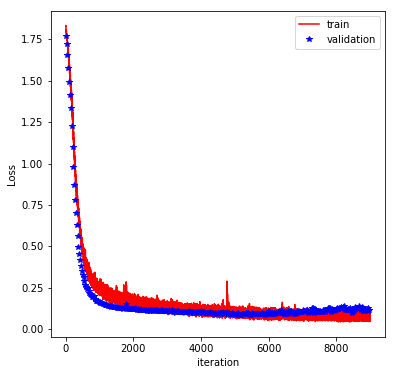

In [14]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 25 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

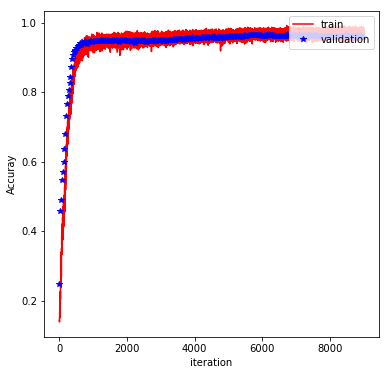

In [15]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 25 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [16]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-crnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

Test accuracy: 0.892917
